In [1]:
import os
import sys
import random
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import time
from tqdm import tqdm
import itertools
import io
import sklearn
import sklearn.cluster
import tensorflow as tf

import scipy
import scipy.special

from mpnn import MessagePassing, ReadoutGraph, Aggregation

In [2]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

version=2.3.0, CUDA=True, GPU=True, TPU=False


In [3]:
strategy = tf.distribute.OneDeviceStrategy("gpu:0")
# strategy = tf.distribute.OneDeviceStrategy("cpu")

In [5]:
#tf.config.experimental_run_functions_eagerly(True)

### Settings

In [4]:
data_path = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/seeding_recordio_v1"
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/seeding/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
                            'batch_size','lr_decay','lr', 'hidden_dim',
                            'n_layers', 'opt'])

args = Args( 
models_path = models_path,
load = False,
nepochs = 50,
ntrain = 500000,
nval = 200000,
nfeatures = 14,
lr_decay = 0 ,
lr = 1e-2,
batch_size = 512,
n_layers = 3,
hidden_dim = 64,
opt='sgd'
        )

### Dataset loading

In [5]:
def _parse_tfr_element(element):
    parse_dic = {
        'X':      tf.io.FixedLenFeature([], tf.string),
        'X_hits': tf.io.FixedLenFeature([], tf.string),
        'y':      tf.io.FixedLenFeature([], tf.int64),
    }
    example_message = tf.io.parse_single_example(element, parse_dic)
    X = example_message['X']
    X_hits = example_message['X_hits']
    y = example_message['y']
    
    arr_X = tf.io.parse_tensor(X, out_type=tf.float32)
    arr_X_hits = tf.io.parse_tensor(X_hits, out_type=tf.float32)
    arr_y = y
    
    #https://github.com/tensorflow/tensorflow/issues/24520#issuecomment-577325475
    arr_X.set_shape( tf.TensorShape(args.nfeatures))
    arr_X_hits.set_shape(tf.TensorShape((None, 4))) #hits features
    
    #arr_y.set_shape( tf.TensorShape(1))
    arr_X = tf.boolean_mask(arr_X, [True,True,True,True,False,False,False,True,True,True,True,True,True,True])
    
    return arr_X, arr_y
  

In [6]:
def _parse_tfr_element_val(element):
    parse_dic = {
        'X':      tf.io.FixedLenFeature([], tf.string),
        'X_hits': tf.io.FixedLenFeature([], tf.string),
        'y':      tf.io.FixedLenFeature([], tf.int64),
        'calo_match':  tf.io.FixedLenFeature([], tf.int64),
    }
    example_message = tf.io.parse_single_example(element, parse_dic)
    X = example_message['X']
    X_hits = example_message['X_hits']
    y = example_message['y']
    calo_match = example_message['calo_match']
    
    arr_X = tf.io.parse_tensor(X, out_type=tf.float32)
    arr_X_hits = tf.io.parse_tensor(X_hits, out_type=tf.float32)
    arr_y = y
    
    #https://github.com/tensorflow/tensorflow/issues/24520#issuecomment-577325475
    arr_X.set_shape( tf.TensorShape(args.nfeatures))
    arr_X_hits.set_shape(tf.TensorShape((None, 4))) #hits features
    
    #arr_y.set_shape( tf.TensorShape(1))
    arr_X = tf.boolean_mask(arr_X, [True,True,True,True,False,False,False,True,True,True,True,True,True,True])
    
    return arr_X, arr_y, calo_match

In [7]:
# Create datasets from TFRecord files.
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/training-*'.format(data_path)))
dataset = dataset.map(_parse_tfr_element,num_parallel_calls=tf.data.experimental.AUTOTUNE)
#dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)

ds_pos_train = dataset.filter(lambda X,Y: Y>0).take(args.ntrain//2)
ds_neg_train = dataset.filter(lambda X,Y: Y==0).take(args.ntrain//2)
ds_pos_test = dataset.filter(lambda X,Y: Y>0).skip(args.ntrain//2).take(args.nval//2)
ds_neg_test = dataset.filter(lambda X,Y: Y==0).skip(args.ntrain//2).take(args.nval//2)

ds_train = tf.data.experimental.sample_from_datasets([ds_pos_train, ds_neg_train], weights=[0.5, 0.5]).batch(args.batch_size).prefetch(10)
ds_test = tf.data.experimental.sample_from_datasets([ds_pos_test, ds_neg_test], weights=[0.5, 0.5]).batch(args.batch_size).prefetch(10)

ds_train_r = ds_train.repeat(args.nepochs)
ds_test_r = ds_test.repeat(args.nepochs)

In [8]:
idata = iter(ds_train)
d = next(idata)

In [9]:
d

(<tf.Tensor: shape=(512, 11), dtype=float32, numpy=
 array([[-1.0747285e+00,  0.0000000e+00,  2.2610114e+00, ...,
          1.0000000e+00,  2.7695561e-03,  1.8398762e-03],
        [ 2.3639750e+00,  1.0000000e+00,  2.4690608e+02, ...,
          1.4000000e+01,  2.1984097e-02,  3.4754455e-02],
        [-1.4559045e+00,  0.0000000e+00,  2.6734716e+01, ...,
          2.0000000e+00,  6.6594514e-03,  1.7531404e-02],
        ...,
        [ 2.7624331e+00,  1.0000000e+00,  7.5275416e+00, ...,
          1.0000000e+00,  4.4929446e-03,  9.5367432e-06],
        [ 8.1789511e-01,  0.0000000e+00,  1.2600629e+00, ...,
          1.0000000e+00,  2.6950529e-03,  1.9139647e-03],
        [-1.7093726e+00, -1.0000000e+00,  2.7304988e+00, ...,
          1.0000000e+00,  9.5692948e-03,  3.6736841e-03]], dtype=float32)>,
 <tf.Tensor: shape=(512,), dtype=int64, numpy=
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
  

In [10]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

In [11]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay
        )
else:
    lr_schedule = args.lr


In [12]:
if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)
    
    
print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/seeding/run_05


In [13]:
callbacks = []
# tb = tf.keras.callbacks.TensorBoard(
#     log_dir=outdir, histogram_freq=2, 
#     write_graph=False, 
#     write_images=True,
#     update_freq='epoch',
#     profile_batch=0,
# )
# tb.set_model(model)
# callbacks += [tb]


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)
callbacks += [cp_callback]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False

)
callbacks += [early_stopping]


In [14]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
from tensorflow.keras import layers, activations, metrics 

with strategy.scope():
    # Define Sequential model with 3 layers
    model = tf.keras.Sequential()
    for nl in range(args.n_layers):
        model.add(layers.Dense(args.hidden_dim, name="layer"+str(nl)))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
    model.add(layers.Dense(1, activation="sigmoid", name="Out"))
    # Call model on a test input
    y = model(d[0])
    
    
    metrics =[
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision', thresholds=[0.3,0.5,0.7]),
      metrics.Recall(name='recall',thresholds=[0.3,0.5,0.7]),
      metrics.AUC(name='auc')
    ]

    
    model.compile(optimizer=args.opt, loss='binary_crossentropy',
        metrics=metrics)
    
    model.summary()
    
    if args.nepochs > 0:
        ret = model.fit(ds_train_r,
            validation_data=ds_test_r, epochs=args.nepochs,
            steps_per_epoch=args.ntrain//args.batch_size, validation_steps=args.nval//args.batch_size,
            verbose=True,
            callbacks=callbacks
        )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (512, 64)                 768       
_________________________________________________________________
batch_normalization (BatchNo (512, 64)                 256       
_________________________________________________________________
re_lu (ReLU)                 (512, 64)                 0         
_________________________________________________________________
layer1 (Dense)               (512, 64)                 4160      
_________________________________________________________________
batch_normalization_1 (Batch (512, 64)                 256       
_________________________________________________________________
re_lu_1 (ReLU)               (512, 64)                 0         
_________________________________________________________________
layer2 (Dense)               (512, 64)                 4

Epoch 14/50
976/976 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9593 - precision: 0.9675 - recall: 0.9466 - auc: 0.9872
Epoch 00014: val_loss did not improve from 0.12323
976/976 [==============================] - 294s 302ms/step - loss: 0.1222 - accuracy: 0.9593 - precision: 0.9675 - recall: 0.9466 - auc: 0.9872 - val_loss: 0.1236 - val_accuracy: 0.9587 - val_precision: 0.9649 - val_recall: 0.9484 - val_auc: 0.9872
Epoch 00014: early stopping


In [16]:
def plot_loss(history, label):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
              label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
              label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


In [21]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.9,1])
    else:
      plt.ylim([0.8,1])

    plt.legend()


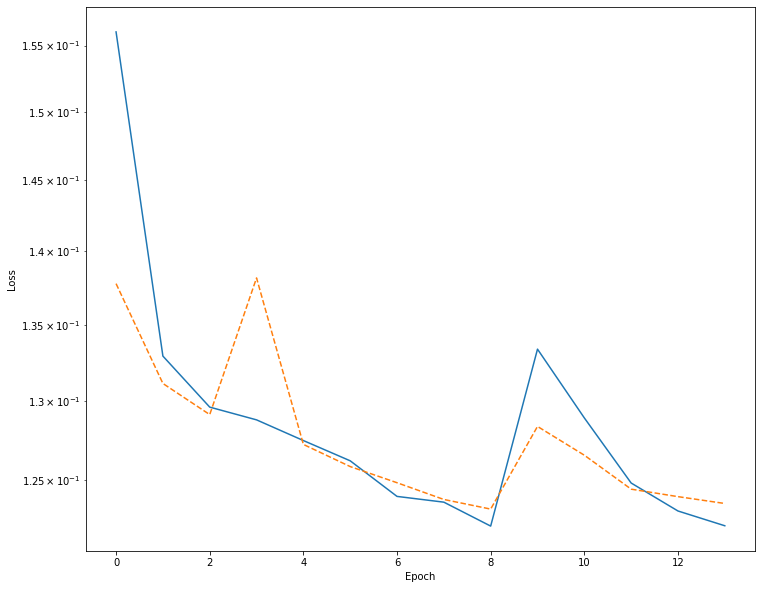

In [18]:
plot_loss(ret, "loss")

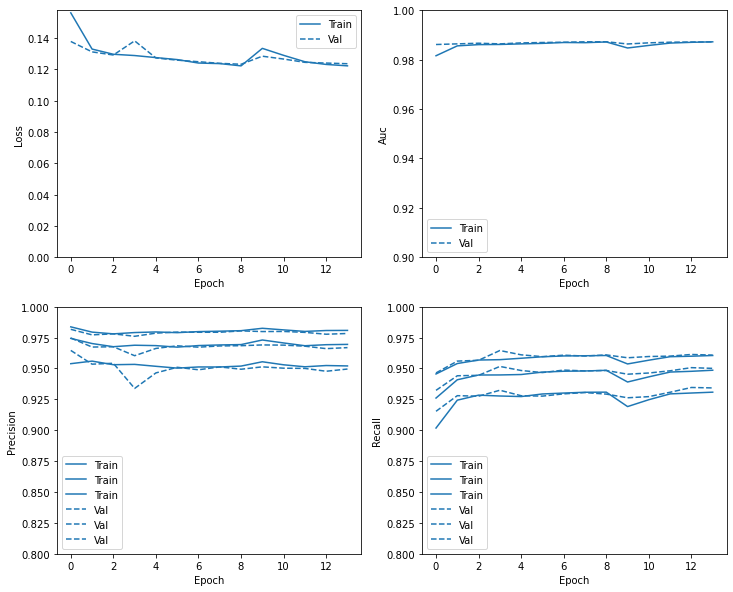

In [22]:
plot_metrics(ret)

In [23]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    

# Evaluation

In [24]:
# Create datasets from TFRecord files.
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/training-*'.format(data_path)))
dataset = dataset.map(_parse_tfr_element_val,num_parallel_calls=tf.data.experimental.AUTOTUNE)
#dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)

ds_pos_test = dataset.filter(lambda X,Y, y: Y>0).skip(args.ntrain//2).take(args.nval//2)
ds_neg_test = dataset.filter(lambda X,Y, y: Y==0).skip(args.ntrain//2).take(args.nval//2)

ds_test = tf.data.experimental.sample_from_datasets([ds_pos_test, ds_neg_test], weights=[0.5, 0.5]).batch(4096)


In [25]:
cols = ["seed_eta","seed_iz", "en_seed", "et_seed",
                    "seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
                    "seed_f5_swissCross","seed_nxtals","seed_etaWidth","seed_phiWidth",
                    ]

from collections import defaultdict
result = defaultdict(list)


for ib, (X, ytrue, ymatch) in enumerate(ds_test):
    if ib % 10 == 0: print(".",end="")
        
    ypred = model(X)
    #print(ypred)
    
    for yt,yp,ym in zip(ytrue, ypred,ymatch):
        result['y'].append(yp.numpy()[0])
        result['y_true'].append(yt.numpy())
        result['calo_match'].append(ym.numpy())
   
    for ix in range(X.shape[0]):
        for ic, col in enumerate(cols):
            result[col].append(X.numpy()[ix,ic])
                
    #if ib>4: break

.....

In [26]:
import pandas as pd
df = pd.DataFrame(result)

In [27]:
df.to_csv(outdir+"/evaluation.csv",index=False,sep=";")

In [33]:
from collections import defaultdict
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#mport mplhep as hep
#lt.style.use(hep.style.CMS)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,4)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
# Overall - both left and right annotation

In [29]:
df

,y,y_true,calo_match,seed_eta,seed_iz,en_seed,et_seed,seed_f5_sigmaIetaIeta,seed_f5_sigmaIetaIphi,seed_f5_sigmaIphiIphi,seed_f5_swissCross,seed_nxtals,seed_etaWidth,seed_phiWidth
0,0.944174,1,1,0.408913,0.0,9.658399,8.903584,0.009180,-3.033149e-05,0.019609,0.801182,1.0,0.007347,0.006478
1,0.019105,0,0,0.693098,0.0,1.312520,1.050048,0.009869,2.479412e-05,0.023468,0.754556,1.0,0.002458,0.008733
2,0.984827,1,1,0.693357,0.0,31.514540,25.208460,0.014155,7.508907e-06,0.016214,0.742056,1.0,0.012601,0.013858
3,0.021210,0,0,1.439976,0.0,2.333211,1.046863,0.016231,3.140210e-04,0.020779,0.583984,1.0,0.002721,0.007965
4,0.998208,1,1,-0.382852,0.0,52.350872,48.735332,0.008253,1.582202e-05,0.020567,0.272701,9.0,0.007468,0.015039
5,0.053019,0,0,0.989260,0.0,2.592078,1.693562,0.000021,-7.642272e-08,0.009344,0.756932,1.0,0.002723,0.008639
6,0.999928,1,1,1.079793,0.0,127.617928,77.727264,0.009160,4.623788e-06,0.010899,0.686770,1.0,0.007761,0.009705
7,0.024992,0,0,-2.674738,-1.0,8.547120,1.172648,0.039573,-5.156850e-04,0.063035,1.000000,1.0,0.004290,0.000142
8,0.999268,1,1,-2.324747,-1.0,134.552353,26.071232,0.026680,-3.323629e-04,0.024471,0.776444,17.0,0.023998,0.016096
9,0.999574,1,1,-0.846529,0.0,100.938606,73.132256,0.009833,-6.144842e-06,0.009873,0.664959,17.0,0.010896,0.011104


In [51]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.3,2.6,3]

df["eta_bin"] = pd.cut(abs(df.seed_eta), etas, labels=list(range(len(etas)-1)))
df["et_bin"] = pd.cut(df.et_seed, ets, labels=list(range(len(ets)-1)))

W0217 12:35:11.147955 140218625079104 font_manager.py:1357] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

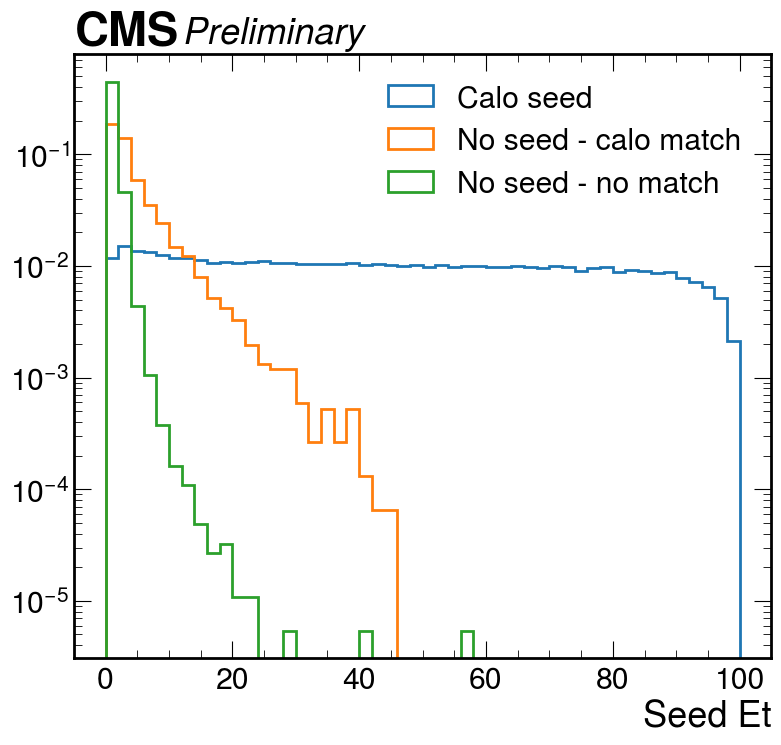

In [53]:
bins = 50
xrange = [0,100]
var = 'et_seed'
title = 'Seed Et'
log = True

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

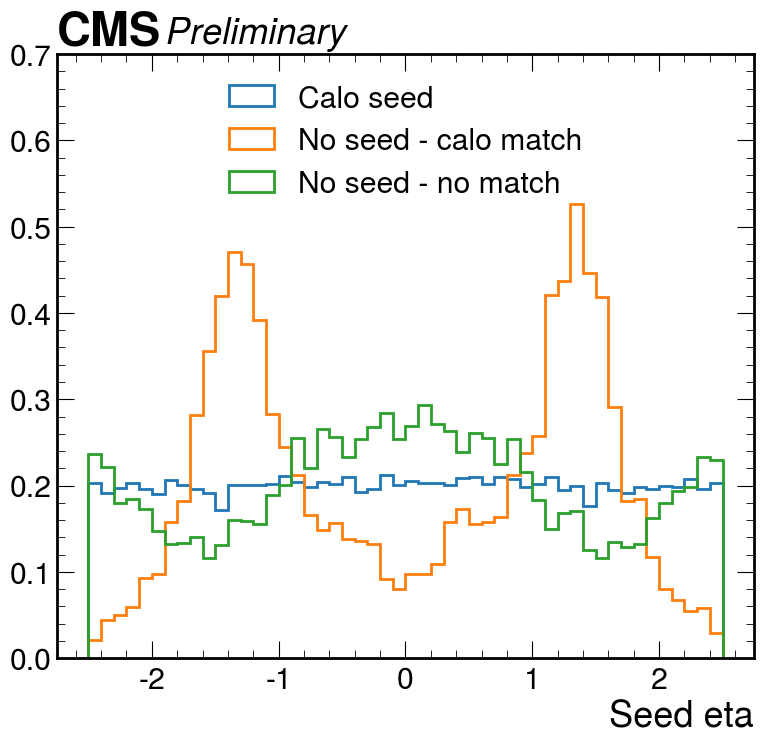

In [74]:
bins = 50
xrange = [-2.5,2.5]
var = 'seed_eta'
title = 'Seed eta'
log = False
ylim = [0, 0.7]


fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

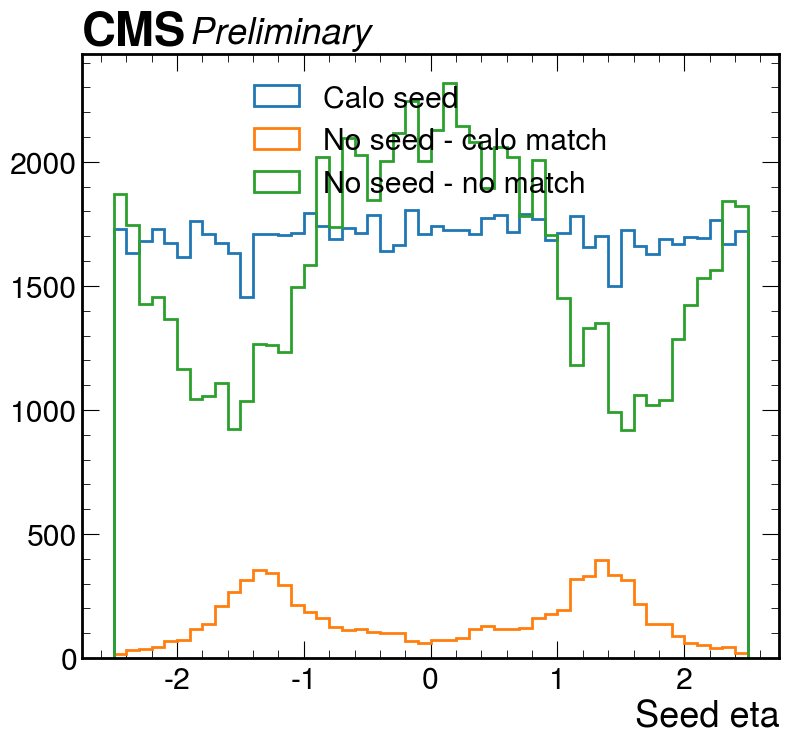

In [76]:
bins = 50
xrange = [-2.5,2.5]
var = 'seed_eta'
title = 'Seed eta'
log = False
density = False
ylim = []


fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=density, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=density, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=density, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

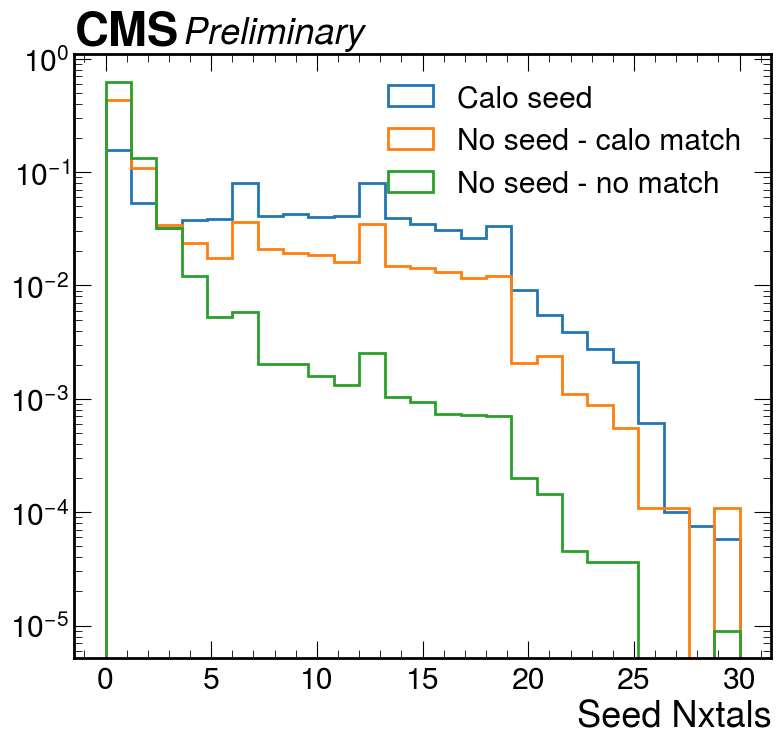

In [54]:
bins = 25
xrange = [0,30]
var = 'seed_nxtals'
title = 'Seed Nxtals'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

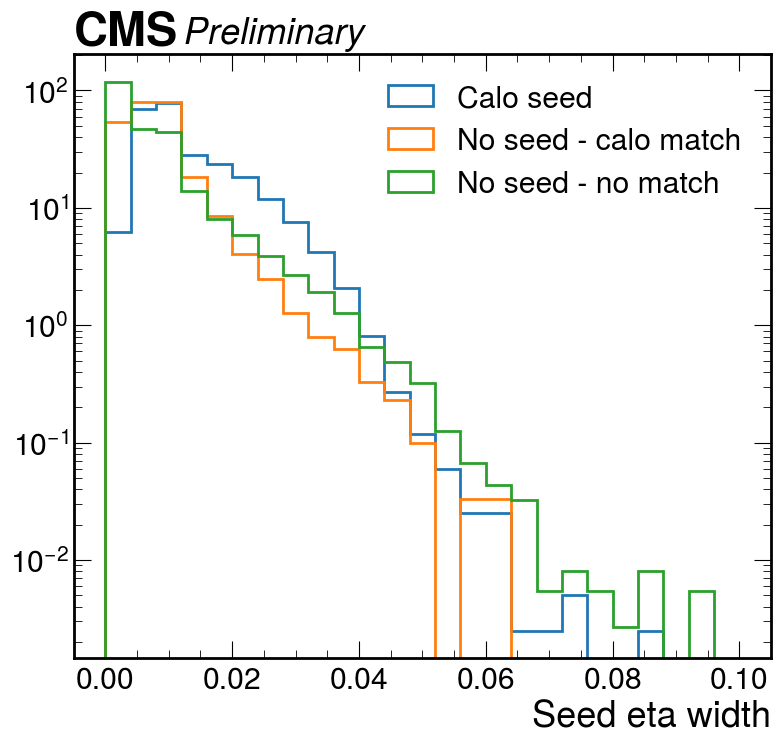

In [55]:
bins = 25
xrange = [0,0.1]
var = 'seed_etaWidth'
title = 'Seed eta width'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

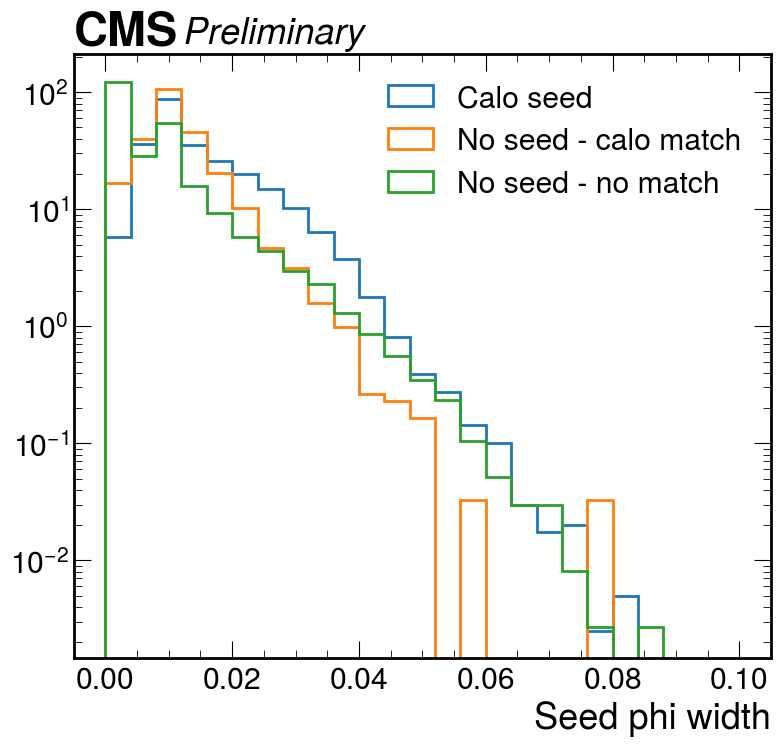

In [56]:
bins = 25
xrange = [0,0.1]
var = 'seed_phiWidth'
title = 'Seed phi width'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

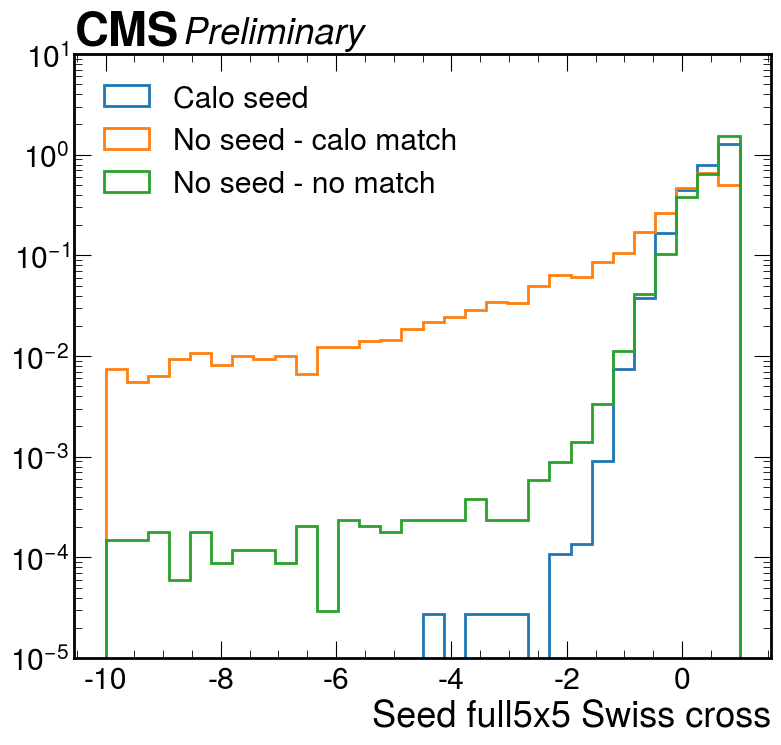

In [57]:
bins = 30
xrange = [-10,1]
var = 'seed_f5_swissCross'
title = 'Seed full5x5 Swiss cross'
log = True
ylim = [1e-5,10]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper left")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

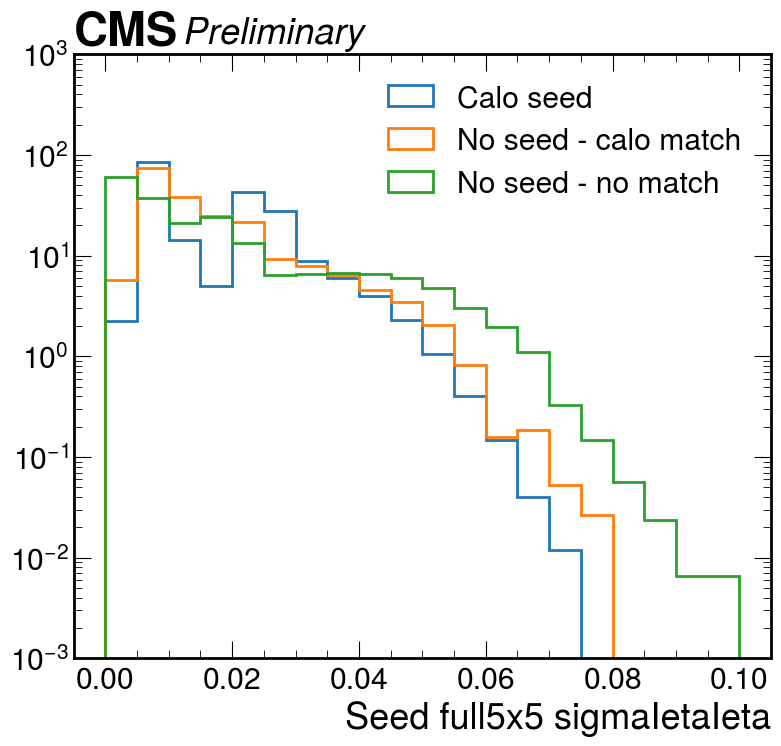

In [59]:
bins = 20
xrange = [0,0.1]
var = 'seed_f5_sigmaIetaIeta'
title = 'Seed full5x5 sigmaIetaIeta'
log = True
ylim = [1e-3, 1e3]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper right")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

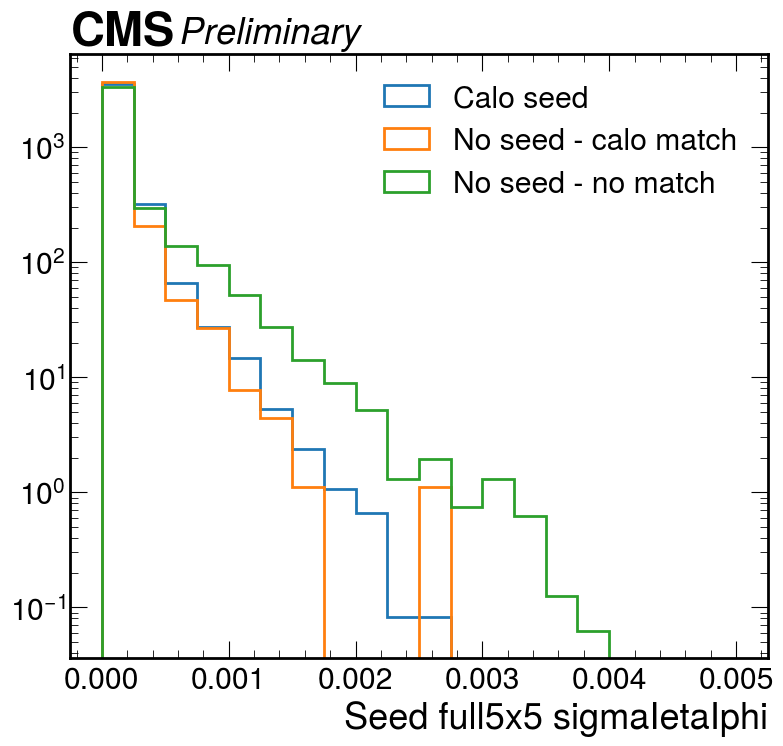

In [60]:
bins = 20
xrange = [0,0.005]
var = 'seed_f5_sigmaIetaIphi'
title = 'Seed full5x5 sigmaIetaIphi'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper right")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

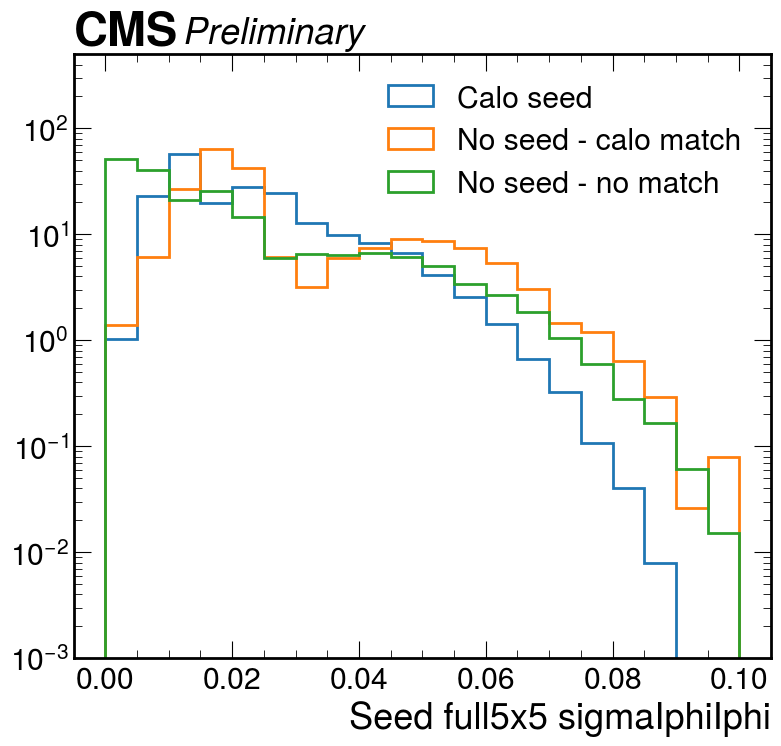

In [62]:
bins = 20
xrange = [0,0.1]
var = 'seed_f5_sigmaIphiIphi'
title = 'Seed full5x5 sigmaIphiIphi'
log = True
ylim = [1e-3, 5e2]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper right")
hep.cms.text("Preliminary ",loc=0)

W0217 15:39:13.742668 140704379979584 font_manager.py:1357] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

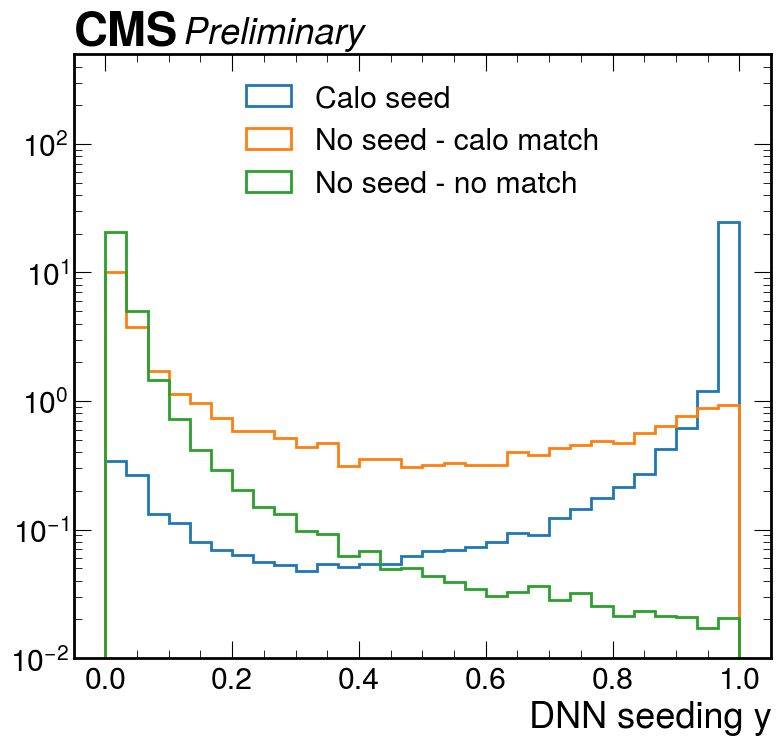

In [35]:
bins = 30
xrange = [0,1]
var = 'y'
title = 'DNN seeding y'
log = True
ylim = [1e-2, 5e2]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

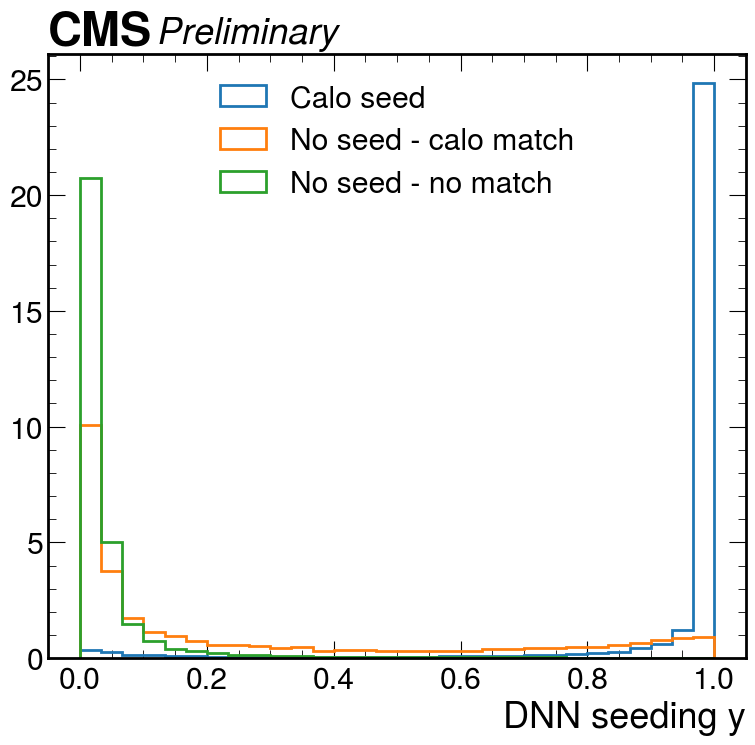

In [36]:
bins = 30
xrange = [0,1]
var = 'y'
title = 'DNN seeding y'
log = False
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

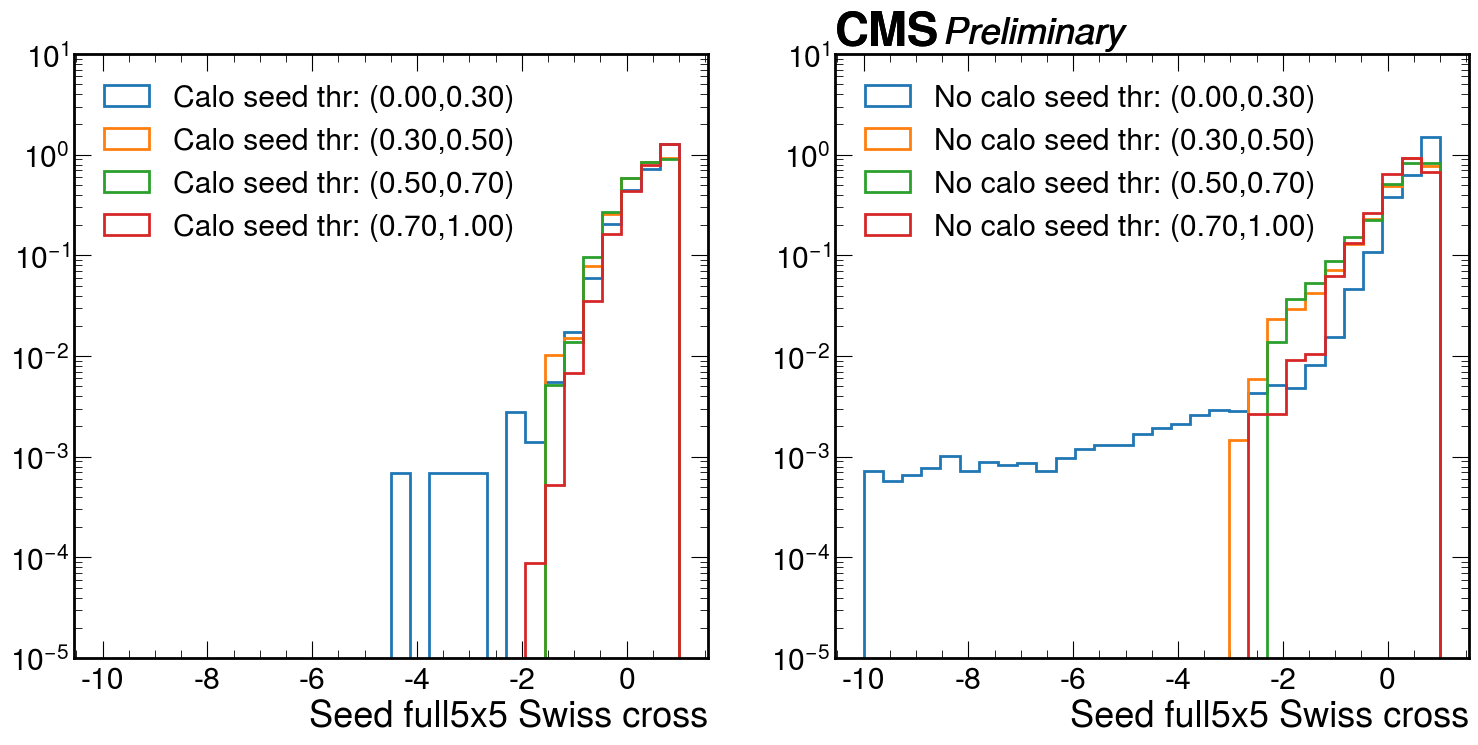

In [43]:
bins = 30
xrange = [-10,1]
var = 'seed_f5_swissCross'
title = 'Seed full5x5 Swiss cross'
log = True
ylim = [1e-5,10]
ybins = [0,0.3,0.5,0.7,1]

fig,  axs = plt.subplots(1,2, figsize=(18,8), dpi=100)
for yt,ax in zip([1,0],axs):
    for yb in range(len(ybins)-1):
        ax.hist(df[(df.y_true==yt) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{} seed thr: ({:.1f},{:.1f})".format("Calo" if yt==1 else "No calo", ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper left")
    hep.cms.text("Preliminary ",loc=0)

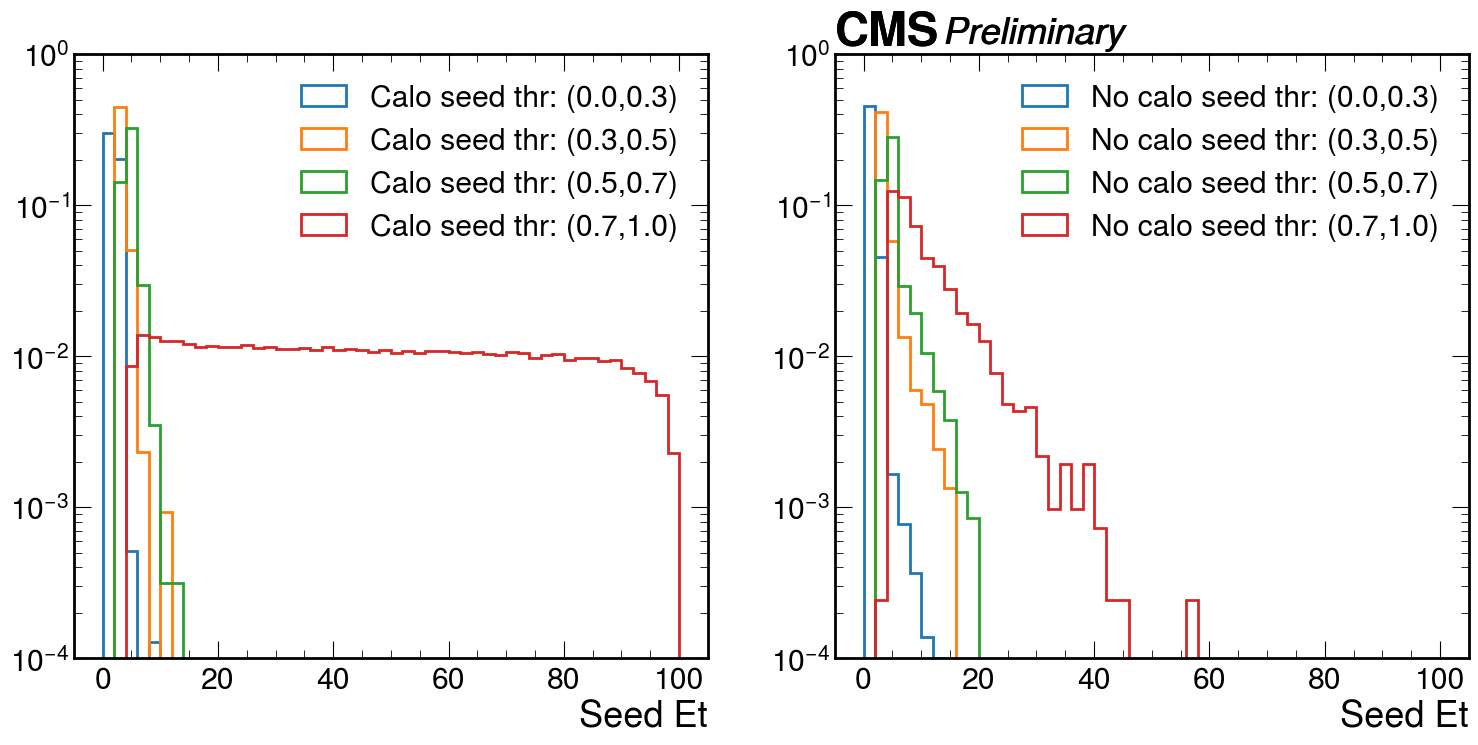

In [47]:
bins = 50
xrange = [0,100]
var = 'et_seed'
title = 'Seed Et'
log = True
ylim = [1e-4, 1]
ybins = [0,0.3,0.5,0.7,1]

fig,  axs = plt.subplots(1,2, figsize=(18,8), dpi=100)
for yt,ax in zip([1,0],axs):
    for yb in range(len(ybins)-1):
        ax.hist(df[(df.y_true==yt) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{} seed thr: ({:.1f},{:.1f})".format("Calo" if yt==1 else "No calo", ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    hep.cms.text("Preliminary ",loc=0)

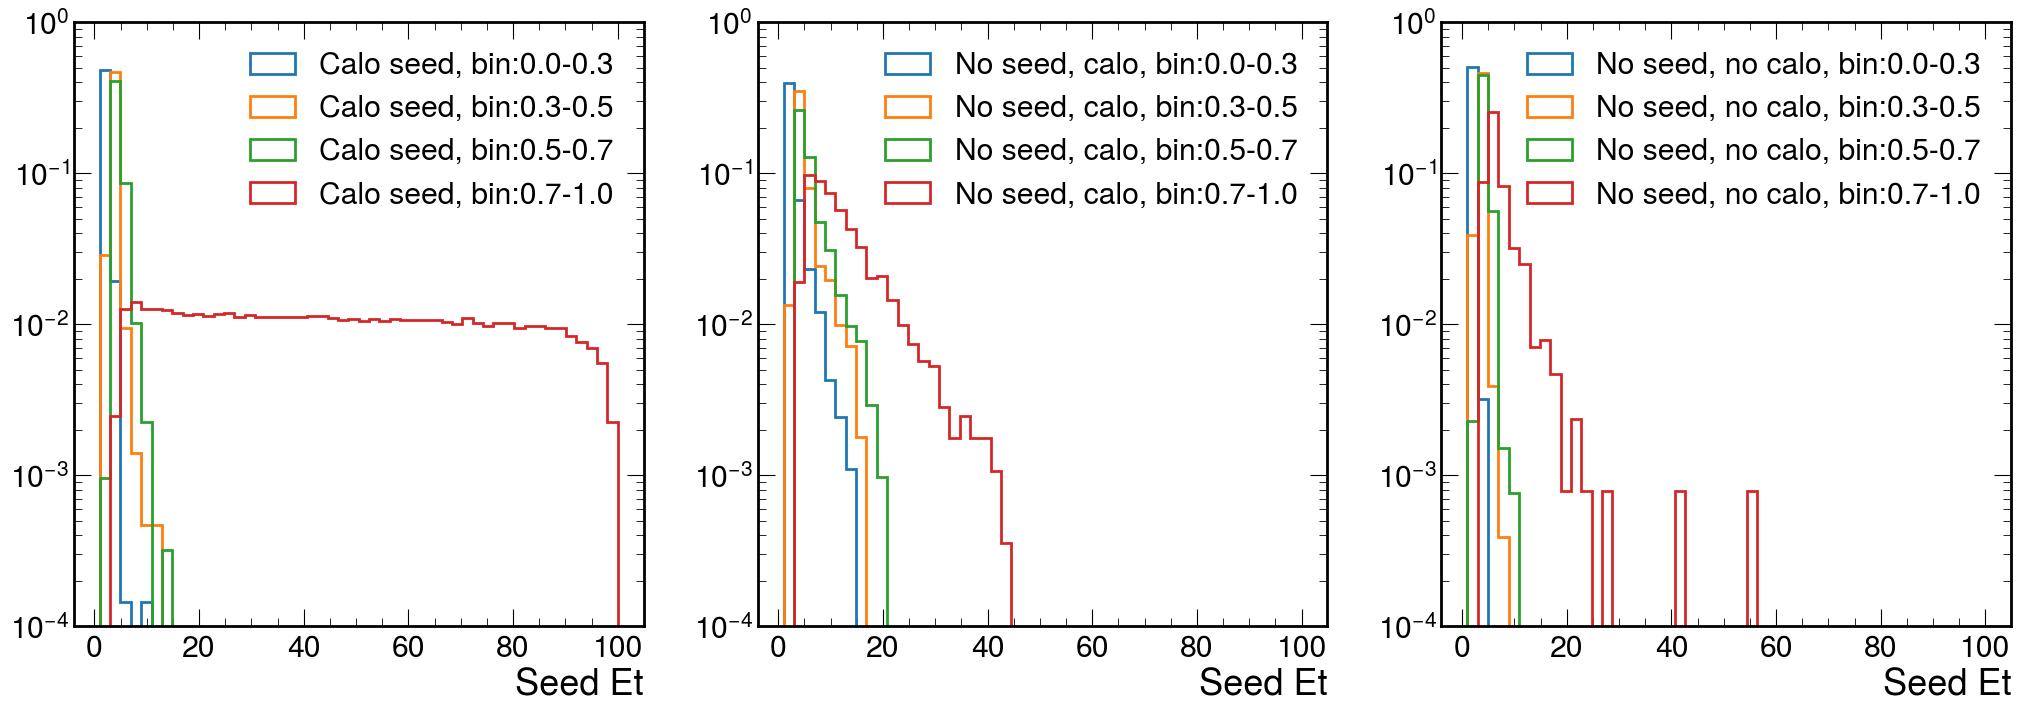

In [60]:
bins = 50
xrange = [1,100]
var = 'et_seed'
title = 'Seed Et'
log = True
ylim = [1e-4, 1]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

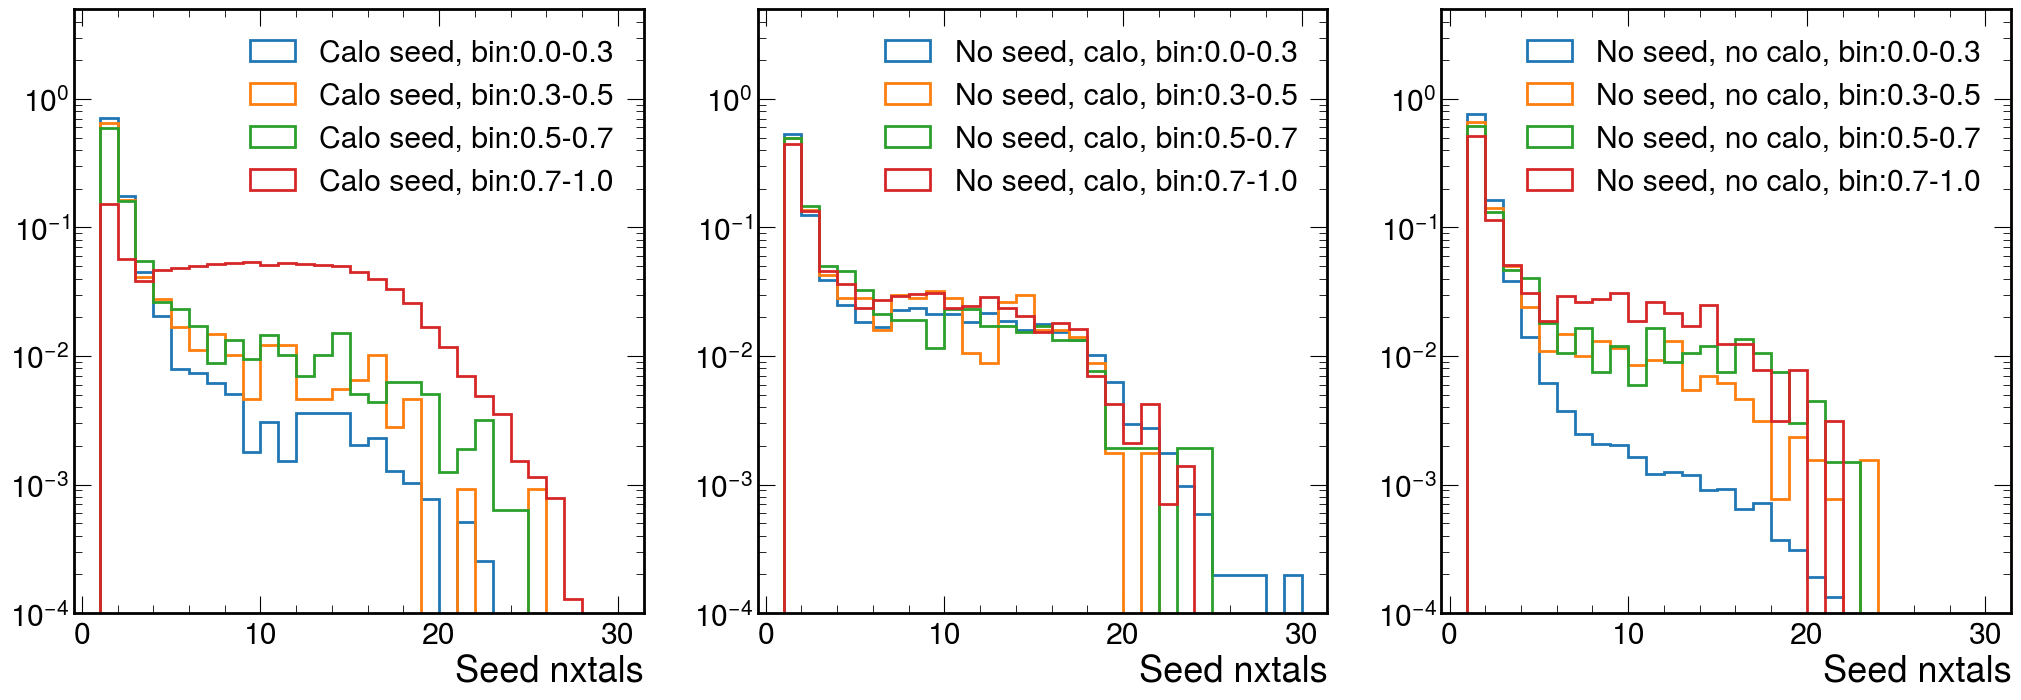

In [66]:
bins = 29
xrange = [1,30]
var = 'seed_nxtals'
title = 'Seed nxtals'
log = True
ylim = [1e-4, 5]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

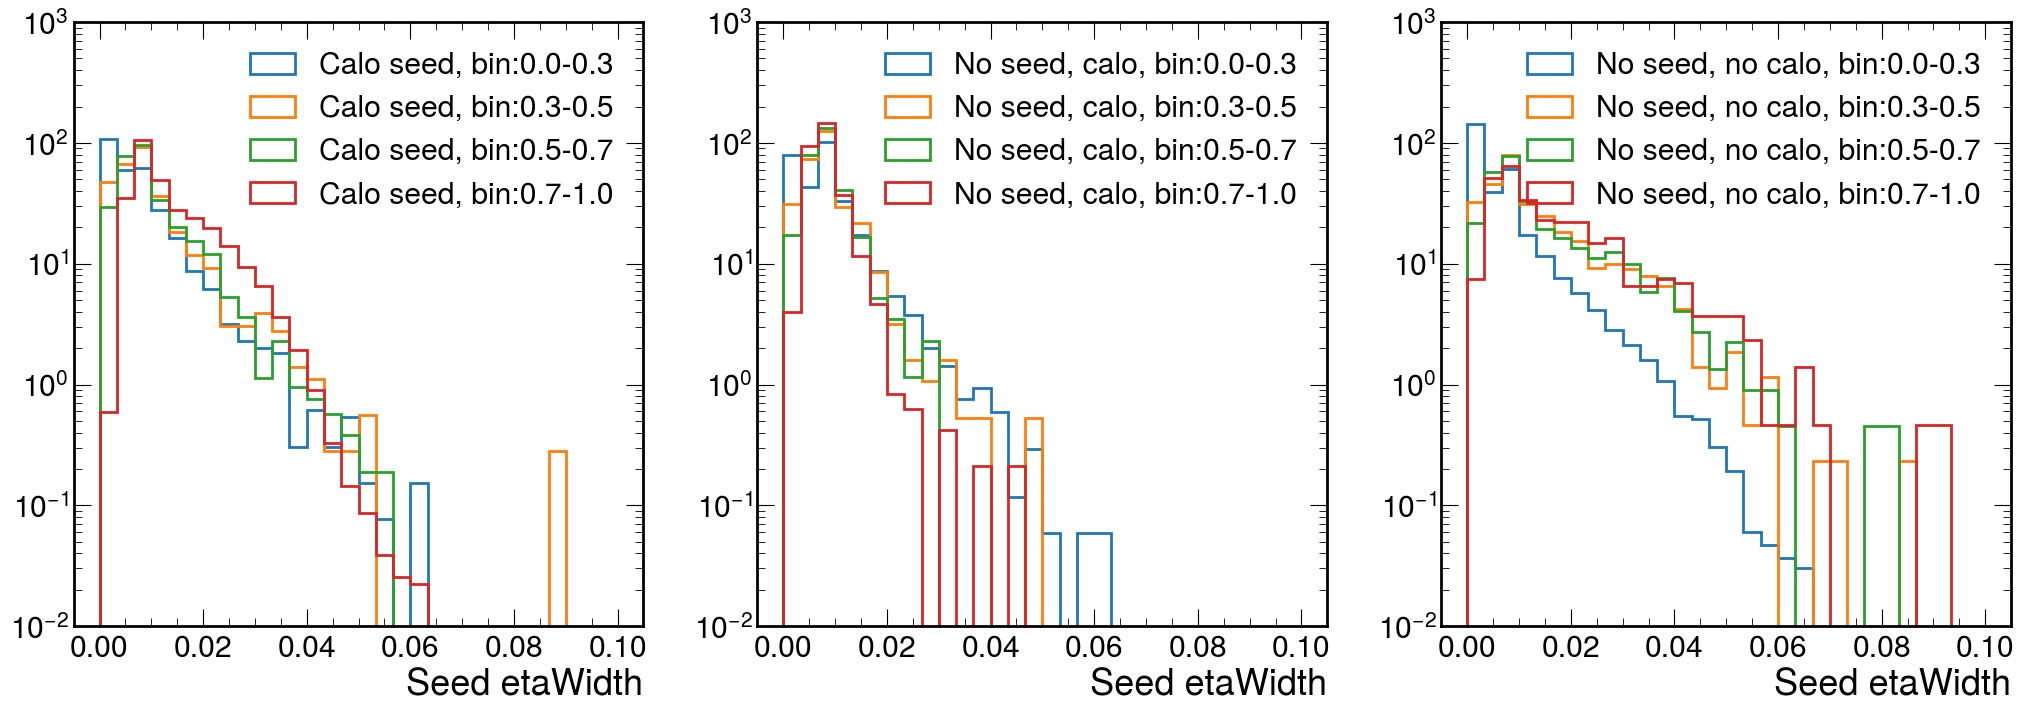

In [71]:
bins = 30
xrange = [0,0.1]
var = 'seed_etaWidth'
title = 'Seed etaWidth'
log = True
ylim = [1e-2, 1e3]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

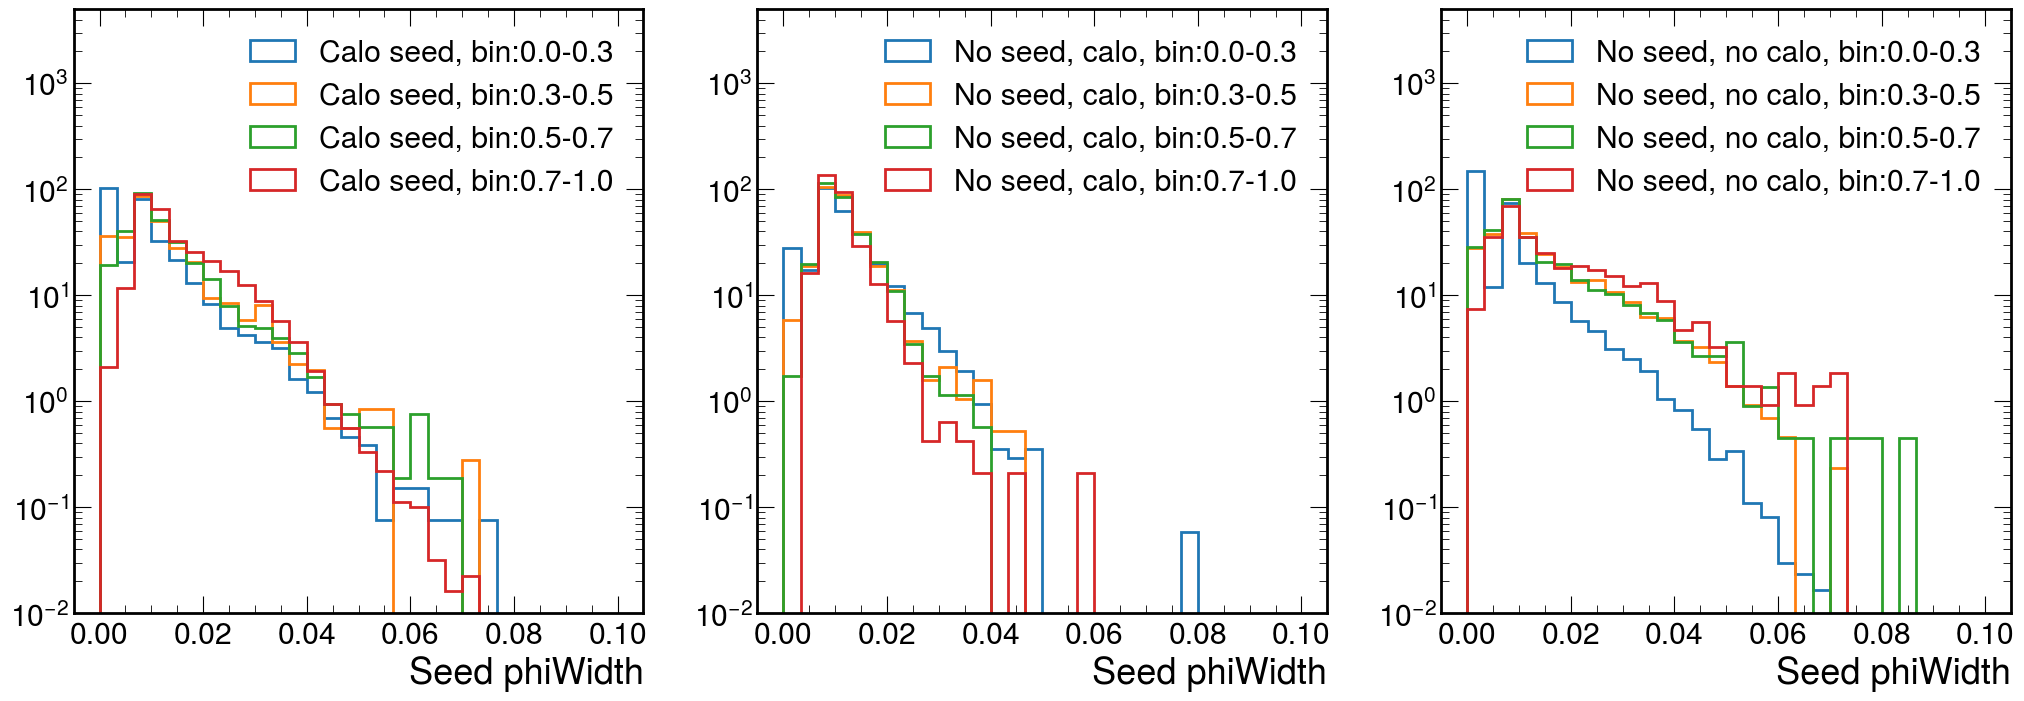

In [73]:
bins = 30
xrange = [0,0.1]
var = 'seed_phiWidth'
title = 'Seed phiWidth'
log = True
ylim = [1e-2, 5e3]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

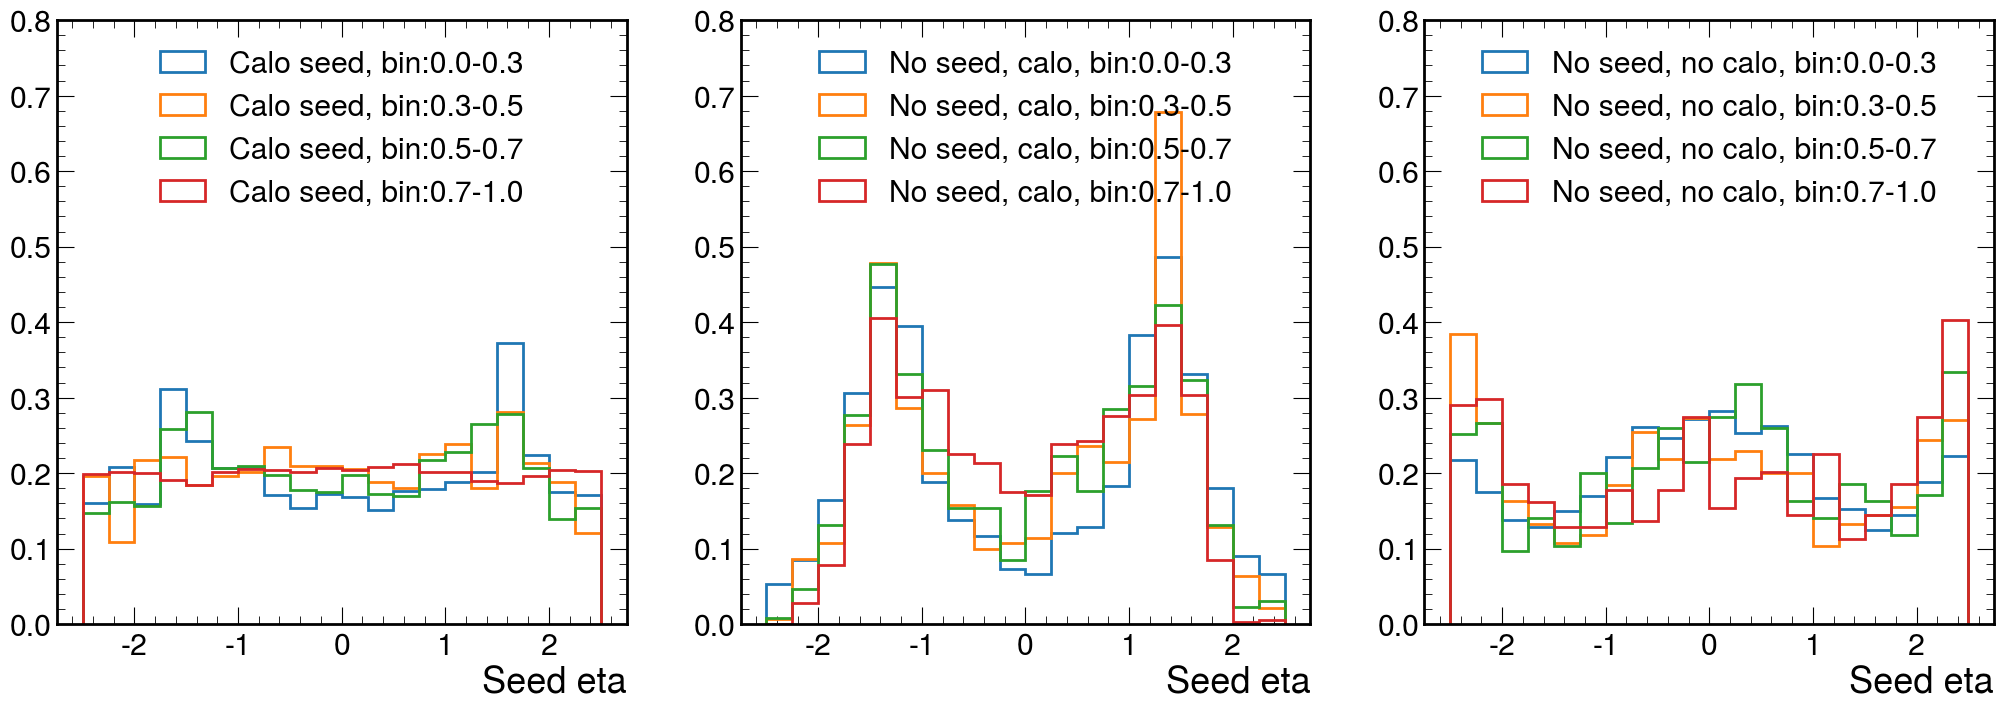

In [81]:
bins = 20
xrange=[-2.5,2.5 ]
var = 'seed_eta'
title = 'Seed eta'
log = False
ylim = [0,0.8]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper center")
    

Text(1560.6495098039215, 1, 'Seed eta')

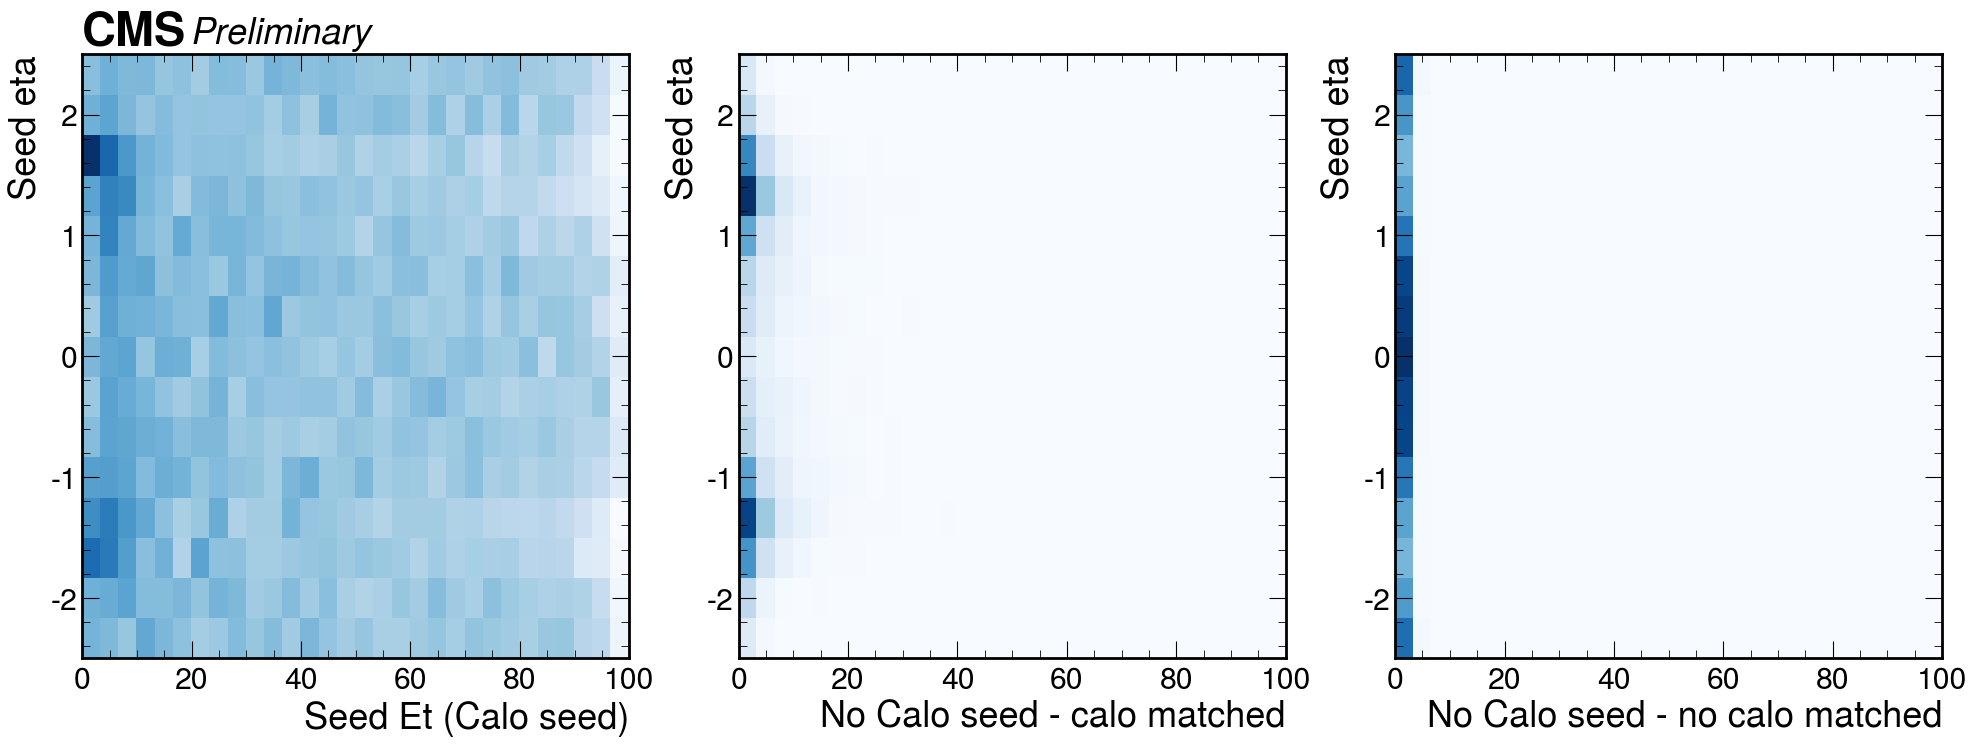

In [115]:
fig,  (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8), dpi=100)
ax1.hist2d(df[(df.y_true==1) ]['et_seed'],df[(df.y_true==1)]['seed_eta'], range=[[0,100],[-2.5,2.5]], bins=[30,15], cmap="Blues")
ax1.set_xlabel("Seed Et (Calo seed)")
ax1.set_ylabel("Seed eta")
hep.cms.text("Preliminary", loc=0, ax=ax1)

ax2.hist2d(df[(df.y_true==0) & (df.calo_match) ]['et_seed'],df[(df.y_true==0) & (df.calo_match) ]['seed_eta'], range=[[0,100],[-2.5,2.5]], bins=[30,15], cmap="Blues")
ax2.set_xlabel("No Calo seed - calo matched")
ax2.set_ylabel("Seed eta")

ax3.hist2d(df[(df.y_true==0) & (df.calo_match==0) ]['et_seed'],df[(df.y_true==0) & (df.calo_match==0) ]['seed_eta'], range=[[0,100],[-2.5,2.5]], bins=[30,15], cmap="Blues")
ax3.set_xlabel("No Calo seed - no calo matched")
ax3.set_ylabel("Seed eta")